In [1]:
import gaia_roman_combined as grc

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib

import astropy
from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u

#matplotlib.rc('text',usetex=True)
font = {'family' : 'serif',
#        'weight' : 'bold',
        'size'   : 16,}
matplotlib.rc('font', **font)

import os

plotpath = './figures/'
if not os.path.isdir(plotpath):
    os.makedirs(plotpath)


In [2]:
'''
This simulation is following the definition of the HLWAS Medium fields defined here:
https://roman-docs.stsci.edu/roman-community-defined-surveys/high-latitude-time-domain-survey#HighLatitudeTimeDomainSurvey-pilot_component
'''

'\nThis simulation is following the definition of the HLWAS Medium fields defined here:\nhttps://roman-docs.stsci.edu/roman-community-defined-surveys/high-latitude-time-domain-survey#HighLatitudeTimeDomainSurvey-pilot_component\n'

In [3]:
#define some default values

roman_pos_floor_err = 0.01*grc.roman_pix_scale #mas, floor or pos uncertainty, (standard is 1% pixel)
gaia_era = 'DR5' #choose from ['DR3','DR4','DR5']

roman_background = 'hltds'
roman_background_level = 'medium'

In [4]:
print(f'Currently Using a Roman position uncertainty floor of {roman_pos_floor_err} mas')

print()

print('Allowed Roman filters are:',grc.allowed_filters)

print()
print('Allowed Roman background choices are:\n',grc.allowed_backgrounds)
print()
print('Allowed Roman background level choices are:',grc.allowed_background_levels)

print()
print('Allowed Roman MultiAccum choices are:')
print('#MA_Name            Exposure Time (seconds)')
for ma_name in grc.allowed_ma_names:
    print(f'{ma_name:20s}{round(grc.ma_integration_times[ma_name],1)}')


Currently Using a Roman position uncertainty floor of 1.078577405 mas

Allowed Roman filters are: ['F062', 'F087', 'F106', 'F129', 'F146', 'F158', 'F184', 'F213']

Allowed Roman background choices are:
 ['hltds', 'gbtds_mid_5stripe', 'hlwas-medium_field1', 'hlwas-medium_field2', 'hlwas-wide_field1', 'hlwas-wide_field2', 'hlwas-wide_field3', 'hlwas-wide_field4']

Allowed Roman background level choices are: ['medium']

Allowed Roman MultiAccum choices are:
#MA_Name            Exposure Time (seconds)
IM_60_6_S           60
IM_66_6             66
IM_76_7_S           76
IM_85_7             85
IM_95_7             95
IM_101_7            101
IM_107_7            107
IM_107_8_S          107
IM_120_8            120
IM_135_8            135
IM_152_9            152
IM_171_10           171
IM_193_11           193
IM_193_14_S         193
IM_225_13           225
IM_250_14           250
IM_284_14           284
IM_294_16           294
IM_307_16           307
IM_360_16           360
IM_409_16           40

In [5]:
'''
Example of how to measure the improved astrometry from combining Roman and Gaia
for the HLTDS. 
'''

#example with 100 magnitudes
n_stars = 100

#Get the new precision from this configuration of
#magnitudes and observing plans. 
#NOTE: specifying ra and dec mean that parallax is used in 
#the calculation. Leaving the ra and dec as None will
#only use positions and PMs in the calculation.

#HLTDS
ra,dec = 242.504,54.510 #ELAIS-N1 Field
ra,dec = 61.241,-48.423 #Euclid Deep Field


'''
Core observing strategy, every 5 days:
    First group:  F087, F129, F184
    Second group: F087, F106, F158

#Filter     MA          N_dithers   Cadence Group
F087		IM_193_11	1           1,2
F129		IM_307_16	1           1
F184	 	IM_409_16	4           1
F158		IM_420_16	1           2
F106		IM_294_16	1           2
'''


roman_filters = ['F087','F106','F129','F158','F184'] 

dithers_per_filter = {
    'F087':1,
    'F106':1,
    'F129':1,
    'F158':1,
    'F184':4,
                     }

mas_per_filter = {
    'F087':'IM_193_11',
    'F106':'IM_294_16',
    'F129':'IM_307_16',
    'F158':'IM_420_16',
    'F184':'IM_409_16',
                     }

pilot_times = Time(2027.0,format='jyear')+np.arange(0,8,1)*16*u.day
core_times = Time(2027.0+2.5,format='jyear')+np.arange(-1*365,1*365,5)*u.day
extended_times_early = core_times.min()-35*u.day+np.arange(-2,1,1)*65*u.day
extended_times_late = core_times.max()+35*u.day+np.arange(0,5,1)*85*u.day

mjds_per_filter = {
    'F087':np.sort(np.concatenate((pilot_times.mjd,extended_times_early.mjd,core_times.mjd,extended_times_late.mjd))),
    'F106':np.sort(np.concatenate((pilot_times.mjd,extended_times_early.mjd,core_times[1::2].mjd,extended_times_late.mjd))),
    'F129':np.sort(np.concatenate((pilot_times.mjd,extended_times_early.mjd,core_times[0::2].mjd,extended_times_late.mjd))),
    'F158':np.sort(np.concatenate((pilot_times.mjd,extended_times_early.mjd,core_times[1::2].mjd,extended_times_late.mjd))),
    'F184':np.sort(np.concatenate((pilot_times.mjd,extended_times_early.mjd,core_times[0::2].mjd,extended_times_late.mjd))),
                     }

epoch_filters = []
n_images_per_epoch = []
epoch_MAs = []
epoch_MJDs = []
for filt in roman_filters:
    curr_n = len(mjds_per_filter[filt])
    epoch_MJDs.extend(mjds_per_filter[filt])
    epoch_filters.extend([filt]*curr_n)
    n_images_per_epoch.extend([dithers_per_filter[filt]]*curr_n)
    epoch_MAs.extend([mas_per_filter[filt]]*curr_n)

#build the observation list using the above data
observation_list = list(zip(epoch_MJDs,epoch_filters,n_images_per_epoch,epoch_MAs))

#array that contains the Roman magnitudes in each filter.
#
#assuming color of stars in all filters is 0 and zeropoint with Gaia is also 0
roman_mags = np.zeros((n_stars,len(roman_filters))) 
roman_mags[:] = np.linspace(15,30,n_stars)[:,None]         #AB mags
gaia_mags = roman_mags[:,0]

new_precision = grc.gaia_roman_astrometric_precision(
    roman_mags = roman_mags,
    roman_filters = roman_filters,
    gaia_mags = gaia_mags,
    roman_pos_floor_err = roman_pos_floor_err,
    observation_list = observation_list,
    gaia_era = gaia_era,
    ra = ra, dec = dec,
    roman_background = roman_background,
    roman_background_level = roman_background_level,
)


/opt/anaconda3/envs/latest_test/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 518 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/anaconda3/envs/latest_test/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 518 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [6]:
#get expected astrometry for all Gaia Data Releases (for comparison)

gaia_drs = ['DR3','DR4','DR5']
gaia_precision_dict = {}
for dr in gaia_drs: 
    gaia_precisions = grc.gaia_astrometry_precision(gaia_mags,era=dr)
    gaia_dracosdec_errs = gaia_precisions[0]
    gaia_ddec_errs = gaia_precisions[1]
    gaia_pmra_errs = gaia_precisions[2]
    gaia_pmdec_errs = gaia_precisions[3]
    gaia_parallax_errs = gaia_precisions[4]
    #geometric-mean uncertainty for position and PM
    gaia_precision_dict[dr] = {
        'gaia_pos_errs':np.sqrt(gaia_dracosdec_errs*gaia_ddec_errs),
        'gaia_pm_errs':np.sqrt(gaia_pmra_errs*gaia_pmdec_errs),
        'gaia_parallax_errs':gaia_parallax_errs,
    }


In [7]:
#can also caculate Roman-only astrometry
roman_alone_astrometry_inv_covs = new_precision.roman_alone_astrometry_inv_covs
good_invs = np.linalg.det(roman_alone_astrometry_inv_covs) > 0
roman_alone_astrometry_covs = np.zeros_like(roman_alone_astrometry_inv_covs)
roman_alone_astrometry_covs[~good_invs] = np.diag(np.ones(roman_alone_astrometry_inv_covs.shape[-1])*np.inf)
roman_alone_astrometry_covs[good_invs] = np.linalg.inv(roman_alone_astrometry_inv_covs[good_invs])

roman_alone_pos_errs = np.power(np.linalg.det(roman_alone_astrometry_covs[:,:2,:2]),1/4)
roman_alone_pm_errs = np.power(np.linalg.det(roman_alone_astrometry_covs[:,2:4,2:4]),1/4)
roman_alone_parallax_errs = np.sqrt(roman_alone_astrometry_covs[:,4,4])


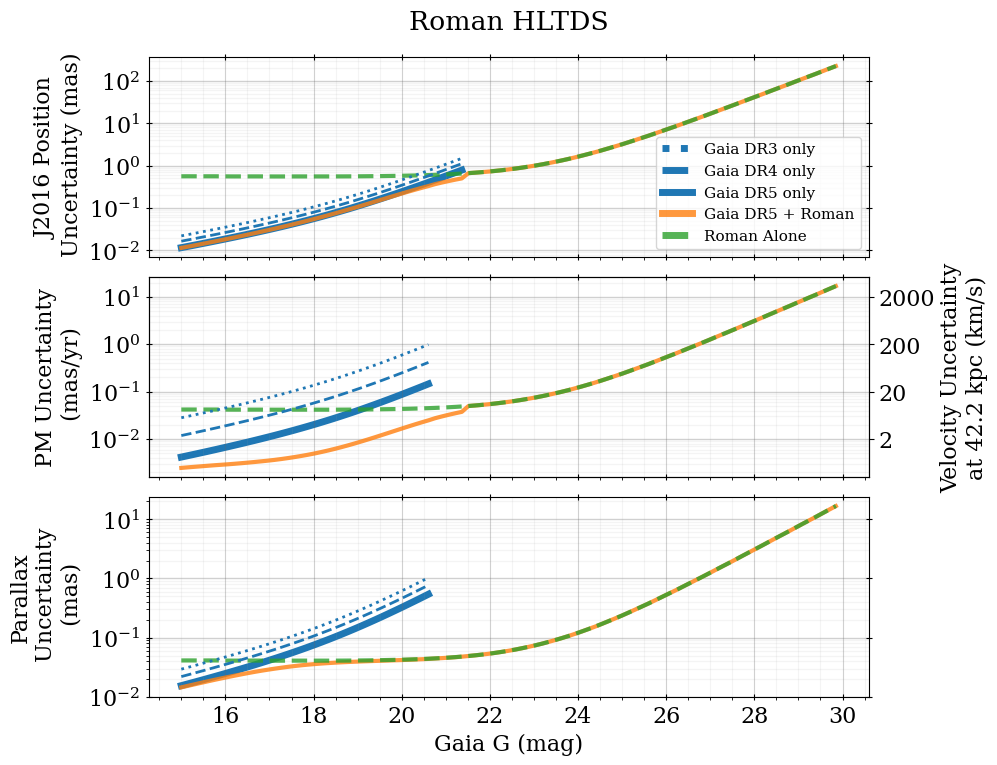

In [11]:
log_scale = True
# log_scale = False


plt.figure(figsize=(10,8))
# plt.figure(figsize=(10,10))

gs = gridspec.GridSpec(3,1,hspace=0.1,left=0.15,right=0.87,top=0.9,bottom=0.1)
ax = plt.subplot(gs[0])    
plt.title('Roman HLTDS',pad=20)
if log_scale:
    ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3, axis='x')
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1, axis='x')
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
dr = 'DR3'
plt.plot(gaia_mags,gaia_precision_dict[dr]['gaia_pos_errs'],label=f'Gaia {dr} only',
     zorder=10,lw=2,color='C0',ls=':')
dr = 'DR4'
plt.plot(gaia_mags,gaia_precision_dict[dr]['gaia_pos_errs'],label=f'Gaia {dr} only',
     zorder=10,lw=2,color='C0',ls='--')

plt.plot(new_precision.gaia_gs,new_precision.gaia_pos_errs,
         label=f'Gaia {new_precision.gaia_era} only',         
         zorder=-10,lw=5)
plt.plot(new_precision.gaia_gs,new_precision.final_pos_errs,
         label=f'Gaia {new_precision.gaia_era} + Roman',lw=3,ls='-',alpha=0.8)
plt.plot(new_precision.gaia_gs,roman_alone_pos_errs,
         label=f'Roman Alone',lw=3,ls='--',alpha=0.8)
# plt.xlabel('Gaia G (mag)')
plt.ylabel('J2016 Position\n Uncertainty (mas)')
ax.set_yticks(10**np.arange(-2,2+1e-10))
if not log_scale:
    ylim = plt.ylim()
    plt.ylim(0,min(ylim[1],10.5))
xlim = plt.xlim()
leg = plt.legend(loc='best',fontsize=11)
for line in leg.get_lines():
    line.set_linewidth(5.0)
ax.set_xticklabels([])
yticks = ax.get_yticks()
ylim = ax.get_ylim()
log_ticks = np.round(np.log10(ylim)+np.array([-1,1]))
major_lines = np.power(10,np.arange(log_ticks[0],log_ticks[1]+1))
minor_mults = np.arange(2,10,1)
for line in major_lines:
    plt.axhline(line,color='#666666',linestyle='-',alpha=0.3,zorder=-1e10,lw=1)
    for minor_mult in minor_mults:
        plt.axhline(line*minor_mult,color='#999999',linestyle='-',alpha=0.1,zorder=-1e10,lw=1)
ax.set_ylim(ylim)

ax = plt.subplot(gs[1])    
if log_scale:
    ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3, axis='x')
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1, axis='x')
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

dr = 'DR3'
plt.plot(gaia_mags,gaia_precision_dict[dr]['gaia_pm_errs'],label=f'Gaia {dr} only',
     zorder=10,lw=2,color='C0',ls=':')
dr = 'DR4'
plt.plot(gaia_mags,gaia_precision_dict[dr]['gaia_pm_errs'],label=f'Gaia {dr} only',
     zorder=10,lw=2,color='C0',ls='--')

plt.plot(new_precision.gaia_gs,new_precision.gaia_pm_errs,
         label=f'Gaia {new_precision.gaia_era} only',
         zorder=-10,lw=5)
plt.plot(new_precision.gaia_gs,new_precision.final_pm_errs,
         label=f'Gaia {new_precision.gaia_era} + Roman',lw=3,ls='-',alpha=0.8)
plt.plot(new_precision.gaia_gs,roman_alone_pm_errs,
         label=f'Roman Alone',lw=3,ls='--',alpha=0.8)
# plt.xlabel('Gaia G (mag)')
ax.set_yticks(10**np.arange(-2,1+1e-10))
if not log_scale:
    ylim = plt.ylim()
    plt.ylim(0,min(ylim[1],2.3))
plt.xlim(xlim)
plt.ylabel('PM Uncertainty\n (mas/yr)')
ax.set_xticklabels([])
yticks = ax.get_yticks()
ylim = ax.get_ylim()
log_ticks = np.round(np.log10(ylim)+np.array([-1,1]))
major_lines = np.power(10,np.arange(log_ticks[0],log_ticks[1]+1))
minor_mults = np.arange(2,10,1)
for line in major_lines:
    plt.axhline(line,color='#666666',linestyle='-',alpha=0.3,zorder=-1e10,lw=1)
    for minor_mult in minor_mults:
        plt.axhline(line*minor_mult,color='#999999',linestyle='-',alpha=0.1,zorder=-1e10,lw=1)
ax.set_ylim(ylim)

#show velocity uncertainty at D kpc
D = 200/4.744
mult = 4.744*D
ylim = np.array(plt.ylim())
yticks = np.array(ax.get_yticks())
ax2 = ax.twinx()
ax2.set_yscale('log')
ax2.set_yticks(yticks*mult)
ax2.set_yticklabels(np.round(yticks*mult).astype(int))
ax2.set_ylim(ylim*mult)
ax2.set_ylabel('Velocity Uncertainty\nat %.1f kpc (km/s)'%D)

ax = plt.subplot(gs[2])    
if log_scale:
    ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3, axis='x')
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1, axis='x')
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

dr = 'DR3'
plt.plot(gaia_mags,gaia_precision_dict[dr]['gaia_parallax_errs'],label=f'Gaia {dr} only',
     zorder=10,lw=2,color='C0',ls=':')
dr = 'DR4'
plt.plot(gaia_mags,gaia_precision_dict[dr]['gaia_parallax_errs'],label=f'Gaia {dr} only',
     zorder=10,lw=2,color='C0',ls='--')

plt.plot(new_precision.gaia_gs,new_precision.gaia_parallax_errs,
         label=f'Gaia {new_precision.gaia_era} only',
         zorder=-10,lw=5)
plt.plot(new_precision.gaia_gs,new_precision.final_parallax_errs,
         label=f'Gaia {new_precision.gaia_era} + Roman',lw=3,ls='-',alpha=0.8)
plt.plot(new_precision.gaia_gs,roman_alone_parallax_errs,
         label=f'Roman Alone',lw=3,ls='--',alpha=0.8)
ax.set_yticks(10**np.arange(-2,1+1e-10))
ylim = plt.ylim()
if not log_scale:
    plt.ylim(0,min(ylim[1],5))
else:
    plt.ylim(ylim[0],min(ylim[1],5e3))
plt.xlim(xlim)

yticks = ax.get_yticks()
ylim = ax.get_ylim()
log_ticks = np.round(np.log10(ylim)+np.array([-1,1]))
major_lines = np.power(10,np.arange(log_ticks[0],log_ticks[1]+1))
minor_mults = np.arange(2,10,1)
for line in major_lines:
    plt.axhline(line,color='#666666',linestyle='-',alpha=0.3,zorder=-1e10,lw=1)
    for minor_mult in minor_mults:
        plt.axhline(line*minor_mult,color='#999999',linestyle='-',alpha=0.1,zorder=-1e10,lw=1)
ax.set_ylim(ylim)


plt.xlabel('Gaia G (mag)')
plt.ylabel('Parallax\n Uncertainty\n (mas)')
plt.savefig(f'{plotpath}HLTDS_best_astrometry.png')
plt.show()


/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_10032/2091012554.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


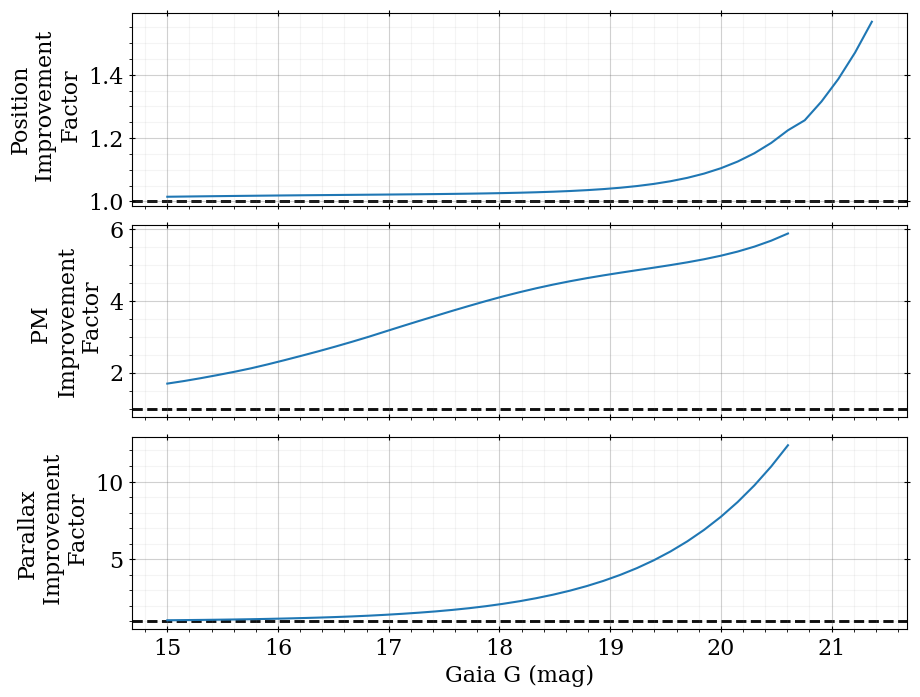

In [9]:
plt.figure(figsize=(10,8))

gs = gridspec.GridSpec(3,1,hspace=0.1)
ax = plt.subplot(gs[0])    

plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(new_precision.gaia_gs,new_precision.gaia_pos_errs/new_precision.final_pos_errs)
# plt.xlabel('Gaia G (mag)')
plt.axhline(1.0,c='k',lw=2,ls='--',zorder=-1e10)
plt.ylabel('Position\n Improvement\n Factor')
ax.set_xticklabels([])
xlim = plt.xlim()

ax = plt.subplot(gs[1])    
# ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(new_precision.gaia_gs,new_precision.gaia_pm_errs/new_precision.final_pm_errs)
# plt.xlabel('Gaia G (mag)')
plt.axhline(1.0,c='k',lw=2,ls='--',zorder=-1e10)
plt.xlim(xlim)
plt.ylabel('PM \nImprovement\n Factor')
ax.set_xticklabels([])

ax = plt.subplot(gs[2])    
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(new_precision.gaia_gs,new_precision.gaia_parallax_errs/new_precision.final_parallax_errs)
plt.axhline(1.0,c='k',lw=2,ls='--',zorder=-1e10)
plt.xlim(xlim)
plt.xlabel('Gaia G (mag)')
plt.ylabel('Parallax\n Improvement\n Factor')
plt.tight_layout()
plt.show()




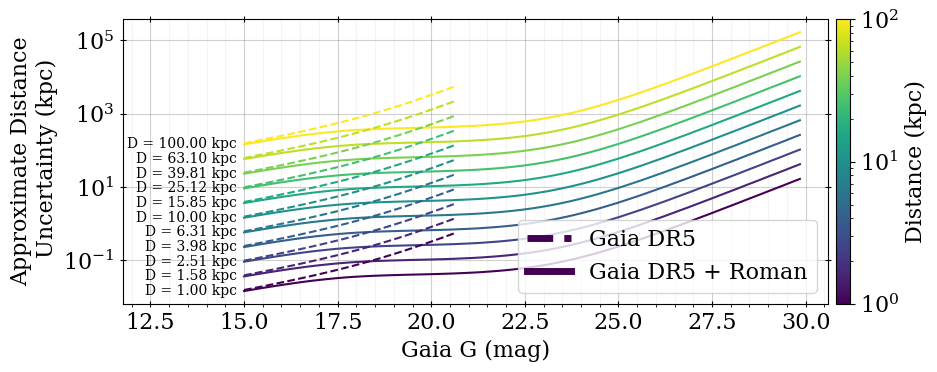

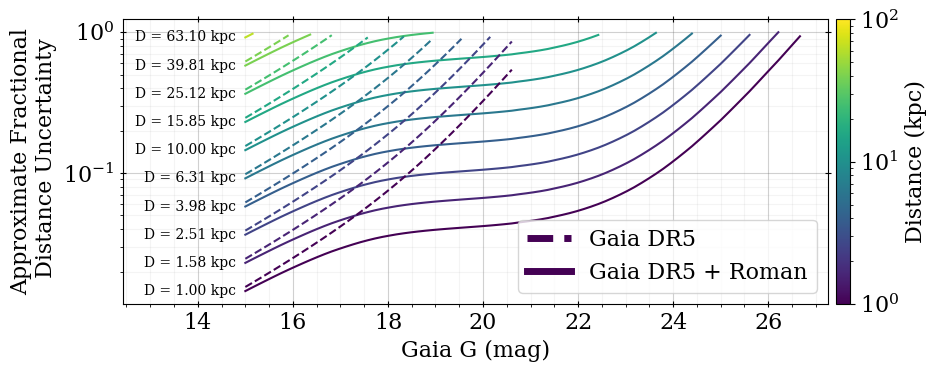

In [56]:
distances = np.logspace(1,1,1)
distances = np.logspace(0,2,11)

cm = matplotlib.cm.viridis
# norm = matplotlib.colors.Normalize(vmin=np.log10(distances.min()),vmax=np.log10(distances.max()))
norm = matplotlib.colors.LogNorm(vmin=distances.min(),vmax=distances.max())
# create a ScalarMappable and initialize a data structure
sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])


plt.figure(figsize=(10,4))
ax = plt.gca()
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
for dist_ind,dist in enumerate(distances):
    if dist_ind == 0:
        plt.plot(new_precision.gaia_gs,new_precision.gaia_parallax_errs*dist**2,
                 zorder=10,ls='--',
                 color=sm.to_rgba(dist),
                 label=f'Gaia {new_precision.gaia_era}')
        plt.plot(new_precision.gaia_gs,new_precision.final_parallax_errs*dist**2,
                 color=sm.to_rgba(dist),
                 label=f'Gaia {new_precision.gaia_era} + Roman')
    else:
        plt.plot(new_precision.gaia_gs,new_precision.gaia_parallax_errs*dist**2,
                 zorder=10,ls='--',
                 color=sm.to_rgba(dist))
        plt.plot(new_precision.gaia_gs,new_precision.final_parallax_errs*dist**2,
                 color=sm.to_rgba(dist))
    plt.text(new_precision.gaia_gs[0]-0.2,new_precision.final_parallax_errs[0]*dist**2,
             'D = %.2f kpc'%(dist),ha='right',va='center',
             fontsize=10,color='k')
leg = plt.legend(loc=4)
for line in leg.get_lines():
    line.set_linewidth(5)
plt.colorbar(sm, ax=ax,label=r'Distance (kpc)',pad=0.01)
plt.xlabel('Gaia G (mag)')
plt.ylabel('Approximate Distance\n Uncertainty (kpc)')
xlim = np.array(ax.get_xlim())
xlim[0] -= 2.5
ax.set_xlim(xlim)
plt.tight_layout()
plt.savefig(f'{plotpath}HLTDS_distance_errs.png')
plt.show()

plt.figure(figsize=(10,4))
ax = plt.gca()
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
for dist_ind,dist in enumerate(distances):
    if dist_ind == 0:
        keep = new_precision.gaia_parallax_errs*dist < 1
        plt.plot(new_precision.gaia_gs[keep],(new_precision.gaia_parallax_errs*dist)[keep],
                 zorder=10,ls='--',
                 color=sm.to_rgba(dist),
                 label=f'Gaia {new_precision.gaia_era}')
        keep = new_precision.final_parallax_errs*dist < 1
        plt.plot(new_precision.gaia_gs[keep],(new_precision.final_parallax_errs*dist)[keep],
                 color=sm.to_rgba(dist),
                 label=f'Gaia {new_precision.gaia_era} + Roman')
    else:
        keep = new_precision.gaia_parallax_errs*dist < 1
        plt.plot(new_precision.gaia_gs[keep],(new_precision.gaia_parallax_errs*dist)[keep],
                 zorder=10,ls='--',
                 color=sm.to_rgba(dist))
        keep = new_precision.final_parallax_errs*dist < 1
        plt.plot(new_precision.gaia_gs[keep],(new_precision.final_parallax_errs*dist)[keep],
                 color=sm.to_rgba(dist))

    if np.sum(keep) > 0:
        plt.text(new_precision.gaia_gs[0]-0.2,new_precision.final_parallax_errs[0]*dist,
                 'D = %.2f kpc'%(dist),ha='right',va='center',
                 fontsize=10,color='k')
leg = plt.legend(loc=4)
for line in leg.get_lines():
    line.set_linewidth(5)
xlim = np.array(ax.get_xlim())
xlim[0] -= 2
ax.set_xlim(xlim)
plt.colorbar(sm, ax=ax,label=r'Distance (kpc)',pad=0.01)
plt.xlabel('Gaia G (mag)')
plt.ylabel('Approximate Fractional\n Distance Uncertainty')
plt.tight_layout()
plt.savefig(f'{plotpath}HLTDS_distance_frac_errs.png')
plt.show()
